In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler

from torchsummary import summary

%matplotlib inline

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 413 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


In [2]:
# import matplotlib as mpl
# print(mpl.get_cachedir())
# print(mpl.matplotlib_fname())

# from matplotlib import font_manager
# for font in font_manager.fontManager.ttflist:
#     print(font.name, "-", font.fname)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

In [3]:
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

def sequence_target_generator(raw_data, window_size=16):
    """
    description:
        输入时间序列，根据时间系列生成样本（特征和标签）
    parameters:
        raw_data: 原始时间序列
        Window_size: 滑动窗口长度
    returns:
        features: 生成的特征集合
        labels: 生成的标签集合
    """
    # raw_data = np.array(raw_data) if type(raw_data) is not np.ndarray else raw_data
    # features, labels = [], []
    sample = []
    for i in range(len(raw_data) - window_size):
        sample.append([raw_data[i:i + window_size], raw_data[i + window_size]])
        # features.append(raw_data[i:i + window_size])
        # labels.append(raw_data[i + window_size])
    # return features, labels
    return sample

def generate_sequences(raw_data, tw, pw):
    """
    paras:
        data: raw time serise - numpy ndarray of the univariate time-series
        tw: Training Window - Integer defining how many steps to look back
        pw: Prediction Window - Integer defining how many steps to predict
    returns:
        dictionary of sequences and targets for all sequences
    """
    data = dict()
    raw_data_length = len(raw_data)
    for i in range(raw_data_length - tw):
        sequence = raw_data[i:i + tw]
        target = raw_data[i + tw : i + tw + pw]
        data[i] = {
            "sequence": sequence,
            "target": target
        }
    return data

test_raw_data_b1 = np.array(range(10))
test_raw_data_b2 = np.array(range(10, 20))
data_b1 = sequence_target_generator(test_raw_data_b1, window_size=8)
data_b2 = sequence_target_generator(test_raw_data_b2, window_size=8)
data = data_b1 + data_b2
print(data_b1)
print(data_b2)

# scaler = MinMaxScaler(feature_range=(0, 1)).fit(test_raw_data.reshape(-1, 1))
# scaled_data = scaler.transform(test_raw_data.reshape(-1, 1))
# data = generate_sequences(scaled_data, tw=8, pw=1)

[[array([0, 1, 2, 3, 4, 5, 6, 7]), 8], [array([1, 2, 3, 4, 5, 6, 7, 8]), 9]]
[[array([10, 11, 12, 13, 14, 15, 16, 17]), 18], [array([11, 12, 13, 14, 15, 16, 17, 18]), 19]]


In [5]:
def evaluation(gt, pred, threshold):
    """
    des:
    paras:
    return:
    """
    
    return

def loss_curve_visualization(tr, va):
    """"
    des:
        打印训练集和验证集上的loss曲线
    """
    fig, ax = plt.subplot()
    ax.plot(tr, label="train")
    ax.plot(va, label="validation")
    plt.show()

In [4]:
class CALCEData(Dataset):
    def __init__(self, data, train=True, window_size=16):
        self.mode = "train" if train else "test"
        self.data = data
        self.sequence, self.target = sequence_target_generator(raw_data=self.data, window_size=window_size)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, index):
        sequence = self.sequence[index]
        target = self.target[index]
        return torch.FloatTensor(sequence), np.float32(target)
    
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        sequence = sample[0].reshape(-1, 1)
        target = sample[1]
        return torch.FloatTensor(sequence), torch.tensor([target])
    
data = BatteryDataset(data)
print(data[0][0].shape, data[0][1])

torch.Size([8, 1]) tensor([8])


In [15]:
# # 读取 CALCE 数据集电池容量数据
# data = np.load("./data/calce/CALCE.npy", allow_pickle=True).item()
# battery_names = list(data.keys())
# battery_caps = {}
# for name in battery_names:
#     print(f"battery {name}")
#     battery_caps[name] = list(data[name]["capacity"])
#     print(f"  length of battery capacity date: {len(battery_caps[name])}")

# bcs235, bcs236, bcs237, bcs238 = (np.array(battery_caps[name], dtype=np.float32) for name in battery_names)
# print(bcs235.shape)

calce_data_path = "../../data/processed_data/calce/calce_capacity.npy"
calce_data = np.load(calce_data_path, allow_pickle=True)
bcs235 = calce_data[0].astype(np.float32)
bcs236 = calce_data[1].astype(np.float32)
bcs237 = calce_data[2].astype(np.float32)
bcs238 = calce_data[3].astype(np.float32)


# 可视化容量衰退
# fig, ax = plt.subplots(1, figsize=(12, 8))
# color = ['b:', 'g--', 'r-.', 'c.']
# for idx, i in enumerate((bcs235, bcs236, bcs237, bcs238)):
#     ax.plot([j for j in range(1, len(i) + 1)], i, color[idx], label="Battery_" + battery_names[idx])
# ax.set(xlabel="", ylabel="", title="容量衰退曲线")
# fig.legend()

window_size = 16
bcs235 = sequence_target_generator(bcs235, window_size=window_size)
bcs236 = sequence_target_generator(bcs236, window_size=window_size)
bcs237 = sequence_target_generator(bcs237, window_size=window_size)
bcs238 = sequence_target_generator(bcs238, window_size=window_size)

# train_dataset = bcs236 + bcs237 + bcs238
# test_dataset = bcs235
# train_dataset = BatteryDataset(train_dataset)
# test_dataset = BatteryDataset(test_dataset)

# batch_size = 16
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# print(train_dataset[0][1])

# X, y = next(iter(train_dataloader)) # 取一个batch的数据
# print(X, y)

In [16]:
USE_CUDA = torch.cuda.is_available()
device = "cuda" if USE_CUDA else "cpu"
print(f"using device: {device}")

class LSTMNet(nn.Module):
    """
    n_features: number of input features (1 for univariate forecasting)
    n_hidden: number of neurons in each hidden layer
    n_outputs: number of outputs to predict for each training example
    sequence_len: number of steps to look back at for prediction
    n_lstm_layers:
    n_deep_layers: number of hidden dense layers after the lstm layer
    use_cuda: 
    dropout: float (0 < dropout < 1) dropout ratio between dense layers
    """
    def __init__(self, n_features, n_hidden, n_outputs, sequence_len, n_lstm_layers=1, n_deep_layers=10, use_cuda=False, dropout=0.2):
        super(LSTMNet, self).__init__()
        
        # 初始化参数
        self.n_hidden = n_hidden
        self.n_lstm_layer = n_lstm_layers
        self.use_cuda = use_cuda

        # lstm层
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_lstm_layers,
            batch_first=True
        )
        
        # 第一个全连接层，使用dropout
        self.fc1 = nn.Linear(n_hidden * sequence_len, n_hidden)
        self.dropout = nn.Dropout(p=dropout)

        # 全连接层后接的dnn
        dnn_layers = []
        for i in range(n_deep_layers):
            if i == n_deep_layers - 1:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_outputs))
            else:
                dnn_layers.append(nn.ReLU())
                dnn_layers.append(nn.Linear(n_hidden, n_hidden))
                if dropout:
                    dnn_layers.append(nn.Dropout(p=dropout))
        self.dnn = nn.Sequential(*dnn_layers)

    def forward(self, x):
        # 初始化hidden state & cell state，并判断cuda可用状态
        hidden_sate = torch.zeros(self.n_lstm_layer, x.shape[0], self.n_hidden)
        cell_state = torch.zeros(self.n_lstm_layer, x.shape[0], self.n_hidden)
        if self.use_cuda:
            hidden_sate = hidden_sate.to(device)
            cell_state = cell_state.to(device)

        self.hidden = (hidden_sate, cell_state)

        x, h = self.lstm(x, self.hidden)
        x = self.dropout(x.contiguous().view(x.shape[0], -1))
        x = self.fc1(x)
        x = self.dnn(x)
        return x

using device: cuda


In [19]:
n_features = 1
n_hidden = 100
n_outputs = 1
sequence_len = 16
n_dnn_layers = 5

lr = 1e-4
epochs = 120

model = LSTMNet(
    n_features=n_features,
    n_hidden=n_hidden,
    n_outputs=n_outputs,
    sequence_len=sequence_len,
    n_deep_layers=n_dnn_layers,
    use_cuda=USE_CUDA
).to(device)
# model = LSTMNet(n_features, n_hidden, n_outputs, sequence_len, n_deep_layers=n_dnn_layers, use_cuda=USE_CUDA).to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

torch.Size([16, 1]) torch.Size([1])
torch.Size([16, 16, 1]) torch.Size([16, 1])
epoch 1, train loss 0.30637668961835973, validation loss 0.02304244413971901
epoch 2, train loss 0.040729236128276954, validation loss 0.007055386435240507
epoch 3, train loss 0.027633944703213995, validation loss 0.021956725046038628
epoch 4, train loss 0.021524354180726925, validation loss 0.007766006048768759
epoch 5, train loss 0.018778122398305123, validation loss 0.021214598789811134
epoch 6, train loss 0.017531381332050157, validation loss 0.008258368819952011
epoch 7, train loss 0.015308225459767786, validation loss 0.01522588450461626
epoch 8, train loss 0.014855237969056854, validation loss 0.035392772406339645
epoch 9, train loss 0.013249971807606559, validation loss 0.01882455311715603
epoch 10, train loss 0.012514831604925114, validation loss 0.02260570041835308
epoch 11, train loss 0.012807249978663369, validation loss 0.02388150803744793
epoch 12, train loss 0.010166446782398824, validation l

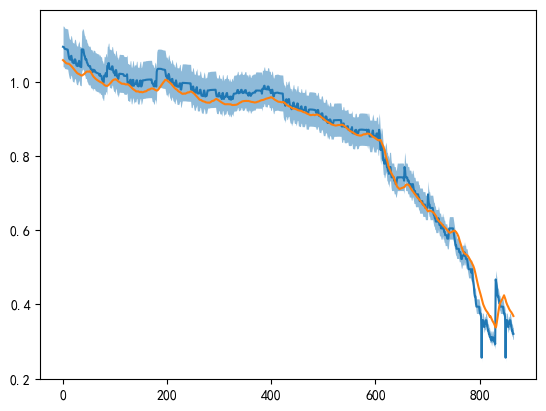

In [20]:
# b35作为测试集

train_dataset = bcs236 + bcs237 + bcs238
test_dataset = bcs235
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

# 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

torch.Size([128, 1]) torch.Size([1])
torch.Size([16, 128, 1]) torch.Size([16, 1])
epoch 1, train loss 0.0007049013322572254, validation loss 0.0016814377158880234
epoch 2, train loss 0.00063321054105707, validation loss 0.0017359227640554309
epoch 3, train loss 0.0006955344450562411, validation loss 0.0017208242788910866
epoch 4, train loss 0.0006892434109637003, validation loss 0.0017719161696732044
epoch 5, train loss 0.0006991842963954344, validation loss 0.0013901728671044111
epoch 6, train loss 0.0006493582236280124, validation loss 0.001577502116560936
epoch 7, train loss 0.0007165882754282305, validation loss 0.001029898296110332
epoch 8, train loss 0.0006482498103005421, validation loss 0.0013559898361563683
epoch 9, train loss 0.0006630040085574071, validation loss 0.0012647667899727821
epoch 10, train loss 0.0007133431594646085, validation loss 0.0011824521934613585
epoch 11, train loss 0.0006878954952680356, validation loss 0.0013451660051941872
epoch 12, train loss 0.000670

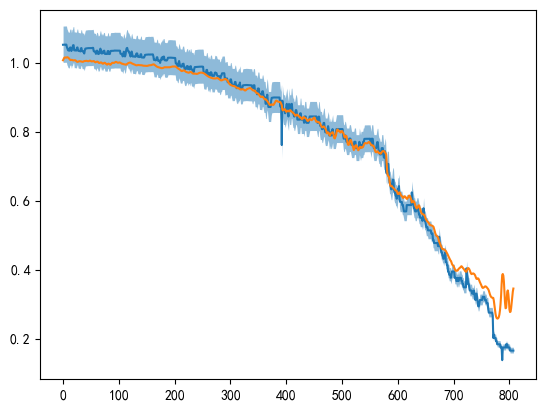

In [60]:
# b36作为测试集

train_dataset = bcs235 + bcs237 + bcs238
test_dataset = bcs236
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

torch.Size([128, 1]) torch.Size([1])
torch.Size([16, 128, 1]) torch.Size([16, 1])
epoch 1, train loss 0.0006123844463888274, validation loss 0.0004307599738240242
epoch 2, train loss 0.0005653870296699001, validation loss 0.0004968843422830105
epoch 3, train loss 0.0005311382407231385, validation loss 0.0003974313149228692
epoch 4, train loss 0.0006020921398311131, validation loss 0.0003786813176702708
epoch 5, train loss 0.0005925863204442736, validation loss 0.0004949200665578246
epoch 6, train loss 0.0005603953691446039, validation loss 0.000519804481882602
epoch 7, train loss 0.0006232923721032229, validation loss 0.0004065444227308035
epoch 8, train loss 0.0005516555811482249, validation loss 0.0005122998845763505
epoch 9, train loss 0.0005677312716503174, validation loss 0.00040713572525419295
epoch 10, train loss 0.0005130493216615593, validation loss 0.00047868306864984334
epoch 11, train loss 0.0006007785424643723, validation loss 0.0004986699786968529
epoch 12, train loss 0.0

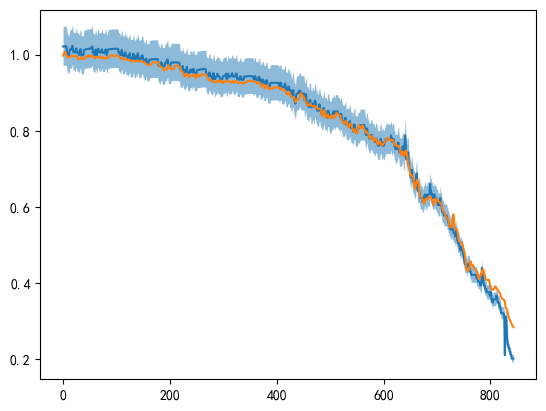

In [61]:
# b37作为测试集

train_dataset = bcs235 + bcs236 + bcs238
test_dataset = bcs237
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)

torch.Size([128, 1]) torch.Size([1])
torch.Size([16, 128, 1]) torch.Size([16, 1])
epoch 1, train loss 0.000485593717923428, validation loss 0.00024911624495871365
epoch 2, train loss 0.0004794138706511269, validation loss 0.00024251858121715486
epoch 3, train loss 0.0005212732116978567, validation loss 0.00029173464281484485
epoch 4, train loss 0.00047175198062105237, validation loss 0.0003747039008885622
epoch 5, train loss 0.0005071795669257863, validation loss 0.0003057658323086798
epoch 6, train loss 0.000513137634288495, validation loss 0.00022150081349536777
epoch 7, train loss 0.0005034096752962603, validation loss 0.00020462973043322563
epoch 8, train loss 0.00046397355926340285, validation loss 0.0002061437553493306
epoch 9, train loss 0.0005166477669070518, validation loss 0.0003313891065772623
epoch 10, train loss 0.0004788272259934244, validation loss 0.00035710891825146973
epoch 11, train loss 0.0004705509811945087, validation loss 0.0002455564390402287
epoch 12, train los

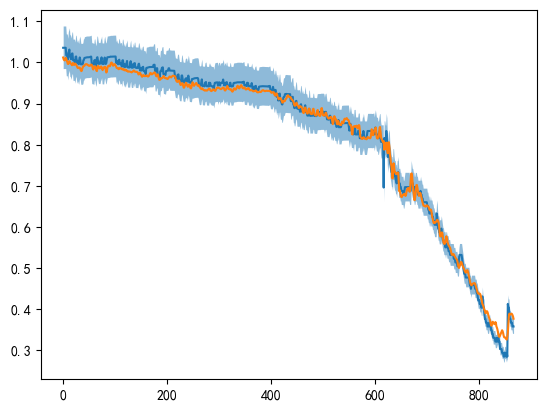

In [62]:
# b38作为测试集

train_dataset = bcs235 + bcs236 + bcs237
test_dataset = bcs238
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)

    # 验证
    model.eval()
    for X, y in test_dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.squeeze().to(device)
            preds = model(X).squeeze()
            error = criterion(preds, y)
        val_loss += error
    val_loss = val_loss / len(test_dataloader)
    val_losses.append(val_loss)

    # 打印训练和验证信息
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

    # 可视化验证集上结果hidden_sate
y_pred, gt, y1, y2 = [], [], [], []
cycle = [i + 1 for i in range(len(test_dataset))]
for X, y in test_dataset:
    y = y.item()
    gt.append(y)
    y1.append(y * (1 + 0.05))
    y2.append(y * (1 - 0.05))
model.eval()
for idx, (X, y) in enumerate(test_dataloader):
    X, y = X.to(device), y.squeeze().to(device)
    y_pred += model(X).cpu().squeeze().tolist()
    

plt.plot(gt)
plt.fill_between(cycle, y1, y2, alpha=0.5)
plt.plot(y_pred)